<h1> <center> <b> Projet - Machine Learning for NLP </b> </center> </h1>

<b> Objectif : </b> Traduire du texte de l'anglais au francais (et reciproquement)

<b> Dataset :  </b> The Europarl parallel corpus is extracted from the proceedings of the European Parliament. it contains text corpora from 21 languages from the proceedings of the European Parliament between 1996 and 2011. The English-French corpus contains 2 million training and 45,000 test sentences. 

- http://www.statmt.org/europarl/

<I> Prise de note : </I>

- La traduction représente LA tache de NLP pour lesquelles les Réseaux de Neurones ont tout chamboulés.
- Nécessité de passer par une architecture : Encoder / Decoder 
- Possibilité d'entrainer notre propre modèle mais très couteux... (1 millions de sentence, c'est le minimum pour commencer à avoir des réponses convenables)
  - Necessite beaucoup de ressource et il s'agit d'un model ent-to-end donc il faut faire des checkpoint régulier au cas où le fichier crash.. 
  - Example GPT2 (TP5)
- Possibilité d'utiliser des modèles Transfromers déjà entrainés : example, modèle T5
- Compliquer d'évaluer quantitativement ce type de modèle : <b> Blue Score </b> à utiliser <br>
- Compléter avec une analyse Qualitative en analysant les traductions directement.

____________________________

In [ ]:
#Telechargement des packages
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
from nltk.tokenize import TreebankWordTokenizer
from nltk.probability import FreqDist

import random
from random import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

from nltk.translate.bleu_score import sentence_bleu

global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **I. Téléchargement des données & Preprocessing**

In [ ]:
#Telechargement des données
! wget https://gitlab.com/rochju/nlp-project/-/raw/master/europarl-fr.txt
! wget https://gitlab.com/rochju/nlp-project/-/raw/master/europarl-en.txt

--2021-04-24 16:15:49--  https://gitlab.com/rochju/nlp-project/-/raw/master/europarl-fr.txt
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘europarl-fr.txt’

europarl-fr.txt         [ <=>                ] 330.85M  47.8MB/s    in 6.9s    

2021-04-24 16:16:00 (47.8 MB/s) - ‘europarl-fr.txt’ saved [346919801]

--2021-04-24 16:16:00--  https://gitlab.com/rochju/nlp-project/-/raw/master/europarl-en.txt
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘europarl-en.txt’

europarl-en.txt         [  <=>               ] 287.55M  46.6MB/s    in 6.3s    

2021-04-24 16:16:09 (45.9 MB/s) - ‘europarl-en.

In [ ]:
with open('europarl-en.txt', 'r', encoding='utf-8') as file:
    data = file.read()

with open('europarl-fr.txt', 'r', encoding='utf-8') as file:
    donnees = file.read()

In [ ]:
#Separation des phrases
sentences = data.split('\n')
phrases = donnees.split('\n')
print(f"Il y a {len(sentences)} phrases dans la base")

del(data)
del(donnees)

def tokenize_data(sentences, phrases):
  sentences = list(map(lambda x: x.lower(), sentences))
  phrases = list(map(lambda x: x.lower(), phrases))

  #Tokenisation
  tokenizer = TreebankWordTokenizer()
  sentences_token = list(map(lambda x: tokenizer.tokenize(x), sentences))
  phrases_token = list(map(lambda x: tokenizer.tokenize(x), phrases))
  #environ 8 min, 9.36/12 GB de RAM

  nb_pairs = len(sentences)
  pairs = [None]*nb_pairs

  #list to create pairs of sentences : the input and the target
  for pair_id in range(nb_pairs):
    pairs[pair_id] = [sentences_token[pair_id], phrases_token[pair_id]]

  return pairs

Il y a 2007724 phrases dans la base


In [ ]:
pairs = tokenize_data(sentences, phrases)

In [ ]:
#check the length
def is_good_length(pair, min_length=8, max_length=35):
  
  if (len(pair[0]) < min_length) or (len(pair[0]) > max_length):
    return False
  else:
    return True

#remove punctuation
def wo_punctuation(pairs):
  
  symbols = '. , ... - ? ! < > : ( ) " / ; [ ] { } @ # '' ``'.split(' ')
  symbols.append("'")
  sentence = [] #without punctuation
  phrase = [] #without punctuation

  for word in pairs[0]:
    if word not in symbols:
      sentence.append(word)
  for mot in pairs[1]:
    if mot not in symbols:
      phrase.append(mot)

  return [sentence, phrase]

#remove all sentences containing words with few occurences bc size of vocabulary too huge
def pairs_wo_rare_words(pairs, threshold):
  corpus_en = []; corpus_fr = []

  for sent_id in range(len(pairs)):
    sentence = pairs[sent_id][0]; phrase = pairs[sent_id][1]
    corpus_en += sentence; corpus_fr += phrase

  #FreqDist
  vocab_eng = FreqDist(corpus_en)
  vocab_fr = FreqDist(corpus_fr)

  idx_to_del = [] #get all index of sentences containing words with occurences < threshold

  for sent_id in range(len(pairs)):
    sentence = pairs[sent_id][0]
    phrase = pairs[sent_id][1]

    for token in sentence:
      if vocab_eng[token] <= threshold : 
        idx_to_del.append(sent_id)
        break

    for token in phrase:
      if vocab_fr[token] <= threshold : 
        idx_to_del.append(sent_id)
        break

  idx_to_del = list(set(idx_to_del))
  pairs_wo_rare_words = pairs.copy()

  #remove all sentences containing words with occurence < threshold
  for index in sorted(idx_to_del, reverse=True):
    del pairs_wo_rare_words[index]

  return pairs_wo_rare_words

def cleaning_data(pairs):
  pairs = list(filter(lambda x: is_good_length(x, 10, 40), pairs))
  pairs = list(map(lambda x: wo_punctuation(x), pairs))
  pairs_filtered = pairs_wo_rare_words(pairs, threshold = 100)
  return pairs_filtered

#keep only sentences if its length is good, wo punctuation, wo rare words
pairs_filtered = []
pairs_filtered = cleaning_data(pairs)


In [ ]:
print(f'Number of sentences before filtering the length/punctuation/rare words: {len(pairs)} vs after : {len(pairs_filtered)}')

########min = 10 /max = 40 ################## 
# threshold = 100 - Number of sentences before filtering the length/punctuation/rare words: 2007724 vs after : 666359

Number of sentences before filtering the length/punctuation/rare words: 2007724 vs after : 666359


In [ ]:
import pickle 
with open('pairs_filtered.pkl', 'wb') as file:
    pickle.dump(pairs_filtered, file)

# **II. Creating our own model**

**IMPORT DIRECTLY PAIRS_FILTERED**

In [ ]:
import pickle 

#because of RAM limits (12GB)
#saving pairs_filtered (threshold=100, min = 10, max = 40)
#avoid using memory at the beginning when tokenizing and filtering raw data

! wget https://gitlab.com/rochju/nlp-project/-/raw/master/eng_fr_pairs_filtered.pkl

with open('eng_fr_pairs_filtered.pkl', 'rb') as file:
    pairs_filtered = pickle.load(file)

print(f"Number of pairs loaded : {len(pairs_filtered)}")

--2021-04-24 16:00:06--  https://gitlab.com/rochju/nlp-project/-/raw/master/eng_fr_pairs_filtered.pkl
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401955417 (383M) [application/octet-stream]
Saving to: ‘eng_fr_pairs_filtered.pkl’

eng_fr_pairs_filter 100%[===================>] 383.33M   102MB/s    in 3.9s    

2021-04-24 16:00:10 (97.3 MB/s) - ‘eng_fr_pairs_filtered.pkl’ saved [401955417/401955417]

Number of pairs loaded : 657655


In [ ]:
test = pairs_filtered[20]
print('this is test : ', test)

this is test :  [['so', 'parliament', 'should', 'send', 'a', 'message', 'since', 'that', 'is', 'the', 'wish', 'of', 'the', 'vast', 'majority'], ['le', 'parlement', 'devrait', 'dès', 'lors', 'envoyer', 'un', 'message', 'en', 'ce', 'sens', 'étant', 'donné', "qu'une", 'grande', 'majorité', 'des', 'députés', 'le', 'souhaite']]


### *A. Préparation du modèle Encoder/Decoder*

Build a vocabulary

In [ ]:
#return a vocabulary with a unique index for each word in both languages
def vocab_builder(pairs):
  corpus_en = []
  corpus_fr = []

  for sent_id in range(len(pairs)):
    sentence = pairs[sent_id][0]
    phrase = pairs[sent_id][1]
    corpus_en += sentence
    corpus_fr +=  phrase

  #FreqDist
  vocab_eng = FreqDist(corpus_en)
  vocab_fr = FreqDist(corpus_fr)

  #add vocab dictionary with each word and its index
  SOS_token = 0 
  EOS_token = 1
  PAD_token = 2
  Unknown = 3
  dict_eng = {'SOS_token' : SOS_token, 'EOS_token': EOS_token, 'PAD_token': PAD_token, 'Unknown': Unknown}
  dict_fr = {'SOS_token' : SOS_token, 'EOS_token': EOS_token, 'PAD_token': PAD_token, 'Unknown': Unknown}

  for idx, (key, value) in enumerate(vocab_eng.items()):
    dict_eng[key] = idx + 4

  for idx, (key,value) in enumerate(vocab_fr.items()):
    dict_fr[key] = idx + 4

  return dict_eng, dict_fr

dict_eng, dict_fr = vocab_builder(pairs_filtered)

In [ ]:
dict_eng['of']

15

In [ ]:
print(f"Size of english vocabulary : {len(dict_eng)} \nSize of french vocabulary : {len(dict_fr)}")

Size of english vocabulary : 9539 
Size of french vocabulary : 13315


In [ ]:
#convert a sentence of words into indexes
def WordsToIndexes(sentence, dict_lang):
    idx = []
    for word in sentence:
        try:
            idx.append(dict_lang[word])
        except:
            idx.append(dict_lang['Unknown'])
    return idx

#convert a sentence of indexes into words
def IndexesToWords(sentence, dict_reverse):
    words = []
    for idx in sentence:
      words.append(dict_reverse[idx])
    return words

dict_reverse_eng = {val: word for word, val in dict_eng.items()}
dict_reverse_fr = {val: word for word, val in dict_fr.items()}

In [ ]:
#example
exmple = pairs_filtered[20][0]
print(exmple)
print('Words to index : ',WordsToIndexes(exmple, dict_eng))
print('Index to words :', IndexesToWords(WordsToIndexes(exmple, dict_eng), dict_reverse_eng))

['so', 'parliament', 'should', 'send', 'a', 'message', 'since', 'that', 'is', 'the', 'wish', 'of', 'the', 'vast', 'majority']
Words to index :  [186, 59, 69, 187, 7, 188, 160, 65, 88, 13, 93, 15, 13, 189, 190]
Index to words : ['so', 'parliament', 'should', 'send', 'a', 'message', 'since', 'that', 'is', 'the', 'wish', 'of', 'the', 'vast', 'majority']


In [ ]:
#return a tensor encoded with indexes from a sentence
def SentenceToTensor(sentence, dict_lang):

    indexes = WordsToIndexes(sentence, dict_lang)
    indexes.insert(0,0) #start of sequence
    indexes.append(1) #end of sequence

    result = torch.LongTensor(indexes).view(-1)
    if device.type == 'cuda':
        return result.cuda()
    else:
        return result

#return a sentence decoded with words from a tensor encoded
def TensorToSentence(tensor, dict_reverse_lang):
  sent = tensor.cpu().numpy()
  return IndexesToWords(sent,dict_reverse_lang)
  

#converts a pair of sentences (input and target) to a pair of tensors
def PairToTensors(pair, dict_input, dict_target):

    input_tensor = SentenceToTensor(pair[0], dict_input)
    target_tensor = SentenceToTensor(pair[1], dict_target)

    return [input_tensor, target_tensor]

#converts a pair of tensors encoded to a pair of sentences of words
def TensorsToPair(pair, dict_reverse_input, dict_reverse_target):

  reverse_input = TensorToSentence(pair[0], dict_reverse_input)
  reverse_target = TensorToSentence(pair[1], dict_reverse_target)

  return [reverse_input, reverse_target]

**Make batches**

In [ ]:
random.seed(69)
np.random.seed(69)

def make_batches(data, batch_size=20, test_size=0.2):
  shuffle(data)

  nb_batches = int(len(data)/batch_size)
  batches = list(range(nb_batches))
  longest_el = list(range(nb_batches))

  #boucle sur les batches
  for batch_id in range(nb_batches):
    
    start_batch = batch_id*batch_size 
    end_batch = (batch_id+1)*batch_size 
    max_len_input = 0; max_len_target = 0
    inputs = list(range(batch_size))
    targets = list(range(batch_size))
    idx = 0

    #boucles sur les samples du batch
    for pair_id in range(start_batch, end_batch):
      inputs[idx], targets[idx] = PairToTensors(data[pair_id], dict_eng, dict_fr)
      
      #plus long input/target du batch pour padd en conséquence
      if len(inputs[idx]) > max_len_input:
        max_len_input = len(inputs[idx])
      if len(targets[idx]) > max_len_target:
        max_len_target = len(targets[idx])

      idx+=1

    batches[batch_id] = (inputs, targets)
    longest_el[batch_id] = (max_len_input, max_len_target)

  train_batches = batches[0:int((1-test_size)*nb_batches)]
  test_batches = batches[int(-test_size*nb_batches):]  

  return train_batches, test_batches, longest_el

batch_data, test_batch_data, longest_el = make_batches(pairs_filtered, batch_size=64, test_size=0.05)

In [ ]:
print(f'Number of batches in train dataset : {len(batch_data)}')
print(f'Number of batches in test dataset : {len(test_batch_data)}')

Number of batches in train dataset : 9761
Number of batches in test dataset : 513


**Padding**

In [ ]:
#take one batch and pad all the tensors inside
#return two matrices padded_inputs and padded_targets with dimensions : (max_len_inp, batch_size) and (max_len_target, batch_size)
def pad_batch(batch, PAD_token):
    padded_inputs = torch.nn.utils.rnn.pad_sequence(batch[0],padding_value=PAD_token).to(device)
    padded_targets = torch.nn.utils.rnn.pad_sequence(batch[1],padding_value=PAD_token).to(device)
    return (padded_inputs, padded_targets)

(padded_inputs, padded_targets) = pad_batch(batch_data[0], PAD_token=2)

**Building Models**

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, nb_layers, dropout):
        super(EncoderLSTM, self).__init__()
        
        self.input_size = input_size #size of english vocabulary
        self.emb_size = emb_size #size of embedding vectors
        self.hidden_size = hidden_size #size of the NN inside the lstm cell/ (hs,cs) dimensions
        self.nb_layers = nb_layers #nb of layers of lstm cells
        self.dropout = dropout #probability to randomly set to 0 weights

        self.embedding = nn.Embedding(input_size, emb_size) # matrix of weights: each word is a vector of length emb_size
        self.dropout = nn.Dropout(dropout) 
        self.lstm = nn.LSTM(emb_size, hidden_size, nb_layers)

    #the dimension of x is (sequence_length, batch_size)
    def forward(self, x):

        embedded = self.embedding(x) #embedded : (sequence_length , batch_size , emb_size)
        embedded = self.dropout(embedded)
        output, (hidden_state, cell_state) = self.lstm(embedded)  
        #output: (Sequence_length , batch_size , hidden_size)
        #(hs, cs): (num_layers, batch_size size, hidden_size)


        return hidden_state, cell_state

In [ ]:
class DecoderLSTM(nn.Module):
  def __init__(self, emb_size, hidden_size, nb_layers, output_size, dropout):
    super(DecoderLSTM, self).__init__()

    self.emb_size = emb_size #size of embedding vectors
    self.hidden_size = hidden_size #size of the NN inside the lstm cell/ (hs,cs) dimensions
    self.nb_layers = nb_layers #nb of layers of lstm cells
    self.output_size = output_size #size of vocab of language target
    self.dropout = dropout #probability to randomly set to 0 weights

    self.embedding = nn.Embedding(self.output_size, self.emb_size) #each word is a vector of dim emb_size
    self.dropout1 = nn.Dropout(dropout)
    self.lstm = nn.LSTM(self.emb_size, hidden_size, nb_layers) #
    self.fc = nn.Linear(self.hidden_size, self.output_size) #each output of the lstm cells pass through a fc layer
    self.dropout2 = nn.Dropout(dropout)

  #shape of x (32) (batch_size) : first word of each sentence (=SOS_token)
  def forward(self, x, hidden_state, cell_state):

    x = x.unsqueeze(0) #x (1, 32) (1, batch_size)
    embedded = self.embedding(x) #embedded :(1, 32, 300) (1, batch_size, embedding dims) : each word is a vector of size emb_size
    embedded = self.dropout1(embedded)

    output, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state)) 
    #output : (1, batch_size , hidden_size)
    #(hs, cs): (num_layers, batch_size size, hidden_size)

    pred = self.fc(output) #pred (1, batch_size , output_size)
    pred = self.dropout2(pred)
    pred = pred.squeeze(0) #pred (batch_size , output_size)

    return pred, hidden_state, cell_state

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self, EncoderLSTM, DecoderLSTM, output_size, tfr=0.4):
    super(EncoderDecoder, self).__init__()
    self.EncoderLSTM = EncoderLSTM
    self.DecoderLSTM = DecoderLSTM
    self.output_size = output_size
    self.tfr = tfr

  def forward(self, padded_inputs, padded_targets):
    
    batch_size = padded_inputs.shape[1] #number of columns of padded_inputs

    target_len = padded_targets.shape[0] #max_len_target : longest target sentence in the batch
    target_vocab_size = self.output_size #size of target vocabulary
    
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) # (target_len, batch_size, target_vocab_size)

    #(hs, cs) (num_layers, batch_size size, hidden_size) 
    hidden_state_encoder, cell_state_encoder = self.EncoderLSTM(padded_inputs) #context vectors

    # Shape of x : batch_size (32)
    x = padded_targets[0] # SOS_token

    for word in range(1, target_len):
      #output (batch_size, size of target vocab) 
      output, hidden_state_decoder, cell_state_decoder = self.DecoderLSTM(x, hidden_state_encoder, cell_state_encoder)
      outputs[word] = output
      best_guess = output.argmax(1) # 0th dimension is batch size, 1st dimension is word embedding
      
      if random.random() < self.tfr: #Teaching Force Ratio : to speed training and convergence
        x = padded_targets[word] #we pass true words
      else: 
        x = best_guess #we keep the model predictions

    #outputs: (max_len_target, batch_size, size target vocab) 
    return outputs

### *B. Entrainement du modèle*

**Saving and loading models**

In [ ]:
#save model during training
def save_model(epoch, epoch_loss, model_state_dict, optimizer_state_dict):
  update = {'Epoch number': epoch, 'Epoch_Loss': epoch_loss ,'model_state_dict' : model_state_dict, 'optimizer_state_dict': optimizer_state_dict}
  month = time.localtime()[1]; day = time.localtime()[2]; hour = time.localtime()[3]; minute = time.localtime()[4]
  date = str(day) + '-' + str(month) +'_' + str(hour+2) + 'h' +str(minute)
  filename = '/content/EncoderDecoderModel_' + date
  torch.save(update, filename+'.pt')

  if epoch%2 == 0:
    files.download(filename+'.pt')
    print('\nDownloading locally the model ...')
    
  print('\n[...]The model has been saved correctly')

In [ ]:
#load model when we want to resume training
def load_model(filename, model, optimizer):
  saved = torch.load(filename)
  epoch = saved['Epoch number']
  model.load_state_dict(saved['model_state_dict'])
  optimizer.load_state_dict(saved['optimizer_state_dict'])

  return model, optimizer

In [ ]:
#return the translation in french for one input sentence
#will be called at the beginning of each epoch to observe the training process
def translate(sentence, encoder_decoder, dict_eng, dict_fr, dict_reverse_fr, max_length=35): #maximum length of sentences is 35
   
  tensor_sent = SentenceToTensor(sentence, dict_eng).view(-1, 1)
  
  with torch.no_grad():
    hidden_state, cell_state = encoder_decoder.EncoderLSTM(tensor_sent)

  outputs_token = [dict_fr['SOS_token']] #output begins with SOS token

  for word_id in range(max_length):
    previous_token = torch.LongTensor([outputs_token[-1]]).to(device)

    with torch.no_grad():
      outputs, hidden_state, cell_state = encoder_decoder.DecoderLSTM(previous_token, hidden_state, cell_state)
      best_guess = outputs.argmax(1).item()

    outputs_token.append(best_guess)

    if outputs.argmax(1).item() == dict_fr['EOS_token']:
        break

  outputs_sentence = IndexesToWords(outputs_token, dict_reverse_fr)

  return outputs_sentence[1:]
  

**TRAINING**

In [ ]:
#encoder
input_size_encoder = len(dict_eng); emb_size_encoder = 300; hidden_size_encoder = 256; num_layers_encoder = 2
dropout = 0.4

encoder_lstm = EncoderLSTM(input_size_encoder, emb_size_encoder,
                           hidden_size_encoder, nb_layers= num_layers_encoder, dropout= dropout).to(device)

#decoder
emb_size_decoder = 300; hidden_size_decoder = 256; nb_layers_decoder = 2
output_size = len(dict_fr)

decoder_lstm = DecoderLSTM(emb_size= emb_size_decoder,
                           hidden_size= hidden_size_decoder, nb_layers= nb_layers_decoder, output_size= output_size, dropout= dropout).to(device)
#encoder_decoder
encoder_decoder = EncoderDecoder(encoder_lstm, decoder_lstm, output_size, tfr=0.8)

print(encoder_decoder)

EncoderDecoder(
  (EncoderLSTM): EncoderLSTM(
    (embedding): Embedding(9539, 300)
    (dropout): Dropout(p=0.4, inplace=False)
    (lstm): LSTM(300, 256, num_layers=2)
  )
  (DecoderLSTM): DecoderLSTM(
    (embedding): Embedding(13315, 300)
    (dropout1): Dropout(p=0.4, inplace=False)
    (lstm): LSTM(300, 256, num_layers=2)
    (fc): Linear(in_features=256, out_features=13315, bias=True)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
)


In [ ]:
print('Nombre de parametres Encoder : ', sum([param.numel() for param in encoder_lstm.parameters()]))
print('Nombre de parametres Decoder : ', sum([param.numel() for param in decoder_lstm.parameters()]))
print('Nombre de parametres total (Encoder + Decoder) : ', sum([param.numel() for param in encoder_decoder.parameters()]))

Nombre de parametres Encoder :  3959428
Nombre de parametres Decoder :  8514183
Nombre de parametres total (Encoder + Decoder) :  12473611


In [ ]:
# Hyperparameters
learning_rate = 0.01
optimizer = optim.Adam(encoder_decoder.parameters(), lr=learning_rate)
PAD_token = 2
criterion = nn.CrossEntropyLoss(ignore_index = PAD_token)

In [ ]:
#If we want to load a model 
new_model = EncoderDecoder(encoder_lstm, decoder_lstm, output_size, tfr=0.8)
encoder_decoder, optimizer = load_model('EncoderDecoderModel_24-4_11h35.pt', new_model, optimizer)

In [ ]:
from tqdm import tqdm
from google.colab import files

start = time.time()
epoch_losses= []
epochs = 14
sentence_to_test = ['this', 'will','enable','us','to','guarantee','an','appropriate','standard','of','living','for','all','european','citizens']
translation_historic = [None] * (epochs-1)

for epoch in tqdm(range(11, epochs+1)):
  
  epoch_loss = 0.0

  #follow translation improvements during the training
  if epoch > 1:
    encoder_decoder.eval() 
    translated_sentence = translate(sentence_to_test, encoder_decoder, dict_eng, dict_fr, dict_reverse_fr, max_length = 15)
    print(f'\nTranslated sentence after {epoch-1} epochs: {translated_sentence}')
    translation_historic.append(translated_sentence)

  encoder_decoder.train(True)
  for batch_id, batch in enumerate(batch_data):
    
    padded_inputs, padded_targets = pad_batch(batch, 2) 

    # Pass the padded_inputs and padded_targets into the encoder_decoder's forward method
    outputs = encoder_decoder(padded_inputs, padded_targets)
    outputs = outputs[1:].reshape(-1, outputs.shape[2]) #ex : torch.Size([49, 15, 36405]) ---> torch.Size([720, 36405])
    padded_targets = padded_targets[1:].reshape(-1)  #row vector of size (max_len_target * batch_size) without SOS_token at the beginning, ex: torch.Size([720])

    # Clear the accumulating gradients
    optimizer.zero_grad()

    # Calculate the loss value for every epoch
    loss = criterion(outputs, padded_targets)

    # Calculate the gradients for weights & biases using back-propagation
    loss.backward()

    # Clips gradient norm of the parameters, the norm is computed over all gradients together
    torch.nn.utils.clip_grad_norm_(encoder_decoder.parameters(), max_norm=1)

    # Update the weights values using the gradients we calculated using bp 
    optimizer.step()
    epoch_loss += loss.item()

    if batch_id%50 == 0:
      print(f"\nEpoch: {epoch} - Batch {batch_id} - Loss:  {round(loss.item(),2)}")

  print(f"\nEPOCH: {epoch} - EPOCH LOSS:  {round(epoch_loss/len(batch_data[0][0]),2)}")

  epoch_losses.append(epoch_loss/len(batch_data[0][0]))
  save_model(epoch, epoch_loss/len(batch_data[0][0]), encoder_decoder.state_dict(), optimizer.state_dict())
  
end = time.time() - start
print('Time elapsed during training : {} minutes'.format(round(end/60,2)))

  0%|          | 0/4 [00:00<?, ?it/s]


Translated sentence after 10 epochs: ['je', 'poules', 'cette', 'roues', 'interventions', 'et', 'le', 'roues', 'collègues', 'le', 'poules', 'fanatiques', 'légalisation', "d'autres", 'légalisation']

Epoch: 11 - Batch 0 - Loss:  7.07

Epoch: 11 - Batch 50 - Loss:  6.74

Epoch: 11 - Batch 100 - Loss:  6.91

Epoch: 11 - Batch 150 - Loss:  7.03

Epoch: 11 - Batch 200 - Loss:  6.7

Epoch: 11 - Batch 250 - Loss:  6.78

Epoch: 11 - Batch 300 - Loss:  6.82

Epoch: 11 - Batch 350 - Loss:  6.95

Epoch: 11 - Batch 400 - Loss:  6.78

Epoch: 11 - Batch 450 - Loss:  6.94

Epoch: 11 - Batch 500 - Loss:  6.72

Epoch: 11 - Batch 550 - Loss:  6.73

Epoch: 11 - Batch 600 - Loss:  6.95

Epoch: 11 - Batch 650 - Loss:  7.11

Epoch: 11 - Batch 700 - Loss:  6.96

Epoch: 11 - Batch 750 - Loss:  7.39

Epoch: 11 - Batch 800 - Loss:  6.81

Epoch: 11 - Batch 850 - Loss:  6.72

Epoch: 11 - Batch 900 - Loss:  6.83

Epoch: 11 - Batch 950 - Loss:  6.82

Epoch: 11 - Batch 1000 - Loss:  7.01

Epoch: 11 - Batch 1050 - Lo

 25%|██▌       | 1/4 [27:26<1:22:19, 1646.62s/it]


[...]The model has been saved correctly

Translated sentence after 11 epochs: ['je', 'roues', 'interventions', 'roues', 'roues', 'félicitations', 'le', 'roues', 'collègues', 'légalisation', 'la', 'légalisation', 'légalisation', 'légalisation', 'légalisation']

Epoch: 12 - Batch 0 - Loss:  6.96

Epoch: 12 - Batch 50 - Loss:  6.91

Epoch: 12 - Batch 100 - Loss:  6.99

Epoch: 12 - Batch 150 - Loss:  7.19

Epoch: 12 - Batch 200 - Loss:  6.8

Epoch: 12 - Batch 250 - Loss:  6.83

Epoch: 12 - Batch 300 - Loss:  7.44

Epoch: 12 - Batch 350 - Loss:  7.02

Epoch: 12 - Batch 400 - Loss:  6.93

Epoch: 12 - Batch 450 - Loss:  6.86

Epoch: 12 - Batch 500 - Loss:  6.98

Epoch: 12 - Batch 550 - Loss:  6.72

Epoch: 12 - Batch 600 - Loss:  6.98

Epoch: 12 - Batch 650 - Loss:  6.9

Epoch: 12 - Batch 700 - Loss:  6.95

Epoch: 12 - Batch 750 - Loss:  6.78

Epoch: 12 - Batch 800 - Loss:  6.75

Epoch: 12 - Batch 850 - Loss:  6.95

Epoch: 12 - Batch 900 - Loss:  6.91

Epoch: 12 - Batch 950 - Loss:  6.78

Epo

### *C. Résultats du modèle*

**TEST THE MODEL**

In [ ]:
#print some translations on the test dataset
from nltk.translate.bleu_score import sentence_bleu

def test_encoder_decoder(test_batch_data, encoder_decoder, nb_sentences_to_print=5):
  batch_test_id = int(np.random.uniform(0, len(test_batch_data), 1)) #randomly choosing one batch in the test dataset
  random_test_batch = test_batch_data[batch_test_id]
  inputs_test, targets_test = random_test_batch
  nb_sent_print = nb_sentences_to_print

  for sent_id, (input_test, target_test) in enumerate(zip(inputs_test, targets_test)):
    encoder_decoder.eval()
    tensor_test = TensorToSentence(input_test, dict_reverse_eng)
    output_test = translate(tensor_test, encoder_decoder, dict_eng, dict_fr, dict_reverse_fr)

    if sent_id <= nb_sent_print:
      print('\n----------------------------------------------------------------------------------------------------------------------------------------------------------------------')
      print('Input : ', TensorToSentence(input_test, dict_reverse_eng))
      print('Target : ',TensorToSentence(target_test, dict_reverse_fr))
      print('Output : ', output_test)
      print('BLEU_SCORE : ', sentence_bleu(TensorToSentence(target_test, dict_reverse_fr), output_test))


In [ ]:
test_encoder_decoder(test_batch_data, encoder_decoder, nb_sentences_to_print=3)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Input :  ['SOS_token', 'it', 'is', 'present', 'with', 'its', 'diplomatic', 'action', 'its', 'development', 'and', 'humanitarian', 'aid', 'its', 'corporate', 'relations', 'in', 'the', 'mediterranean', 'and', 'its', 'participation', 'in', 'peace-keeping', 'forces', 'EOS_token']
Target :  ['SOS_token', 'elle', 'y', 'est', 'présente', 'avec', 'son', 'action', 'diplomatique', 'son', 'aide', 'au', 'développement', 'et', 'humanitaire', 'ses', 'relations', "d'affaires", 'dans', 'la', 'méditerranée', 'et', 'sa', 'participation', 'aux', 'forces', 'de', 'maintien', 'de', 'la', 'paix', 'EOS_token']
Output :  ['je', 'roues', 'roues', 'poules', 'poules', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légalisation', 'légali

# **III. Application du modèle pré-entrainé T5**

In [ ]:
!pip install transformers
!pip install SentencePiece

     |████████████████████████████████| 2.1MB 11.8MB/s 
     |████████████████████████████████| 3.3MB 44.2MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 
     |████████████████████████████████| 1.2MB 11.9MB/s 


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.tokenize.treebank import TreebankWordDetokenizer
import random 

### *A. Chargement du modèle*

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-base')

### *B. Traduction des phrases de notre dataset*


In [ ]:
pairs_translate = [None]*100
target = [None]*100

for i in range(100):
  alea = random.randint(0,len(pairs_filtered))
  input = TreebankWordDetokenizer().detokenize(pairs_filtered[alea][0])
  target = pairs_filtered[alea][1]
  input_ids = tokenizer.encode("translate English to French: " + input, return_tensors="pt") 
  outputs = model.generate(input_ids)
  decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
  pairs_translate[i] = [input, decoded, target]


In [ ]:
pairs_translate[0][1]

"Nous avons simplement décidé qu'il y aura un régime transitoire pour la législature"

In [ ]:
with open('pairs_translate.pkl', 'wb') as file:
    pickle.dump(pairs_translate, file)

### *C. Analyse des résultats*

In [ ]:
output = [pairs_translate[i][1].split() for i in range(100)]

In [ ]:
target = [pairs_translate[i][2] for i in range(100)]

In [ ]:
blue_score = [None]*100

for i in range(100):
  blue_score[i] = sentence_bleu(target[i], output[i])
  #print('BLEU score -> {}'.format(sentence_bleu(target[0], output[0])))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
pairs_translate[i][0]

'it is also a good idea to set up a working group which should include the social partners'

In [ ]:
print(target[i])
print(output[i])
print(sentence_bleu(target[i], output[i], weights=(1, 0, 0, 0)))

["l'idée", 'de', 'créer', 'un', 'groupe', 'de', 'travail', 'incluant', 'les', 'partenaires', 'sociaux', 'est', 'également', 'bonne']
['il', 'est', 'également', 'bon', 'de', 'créer', 'un', 'groupe', 'de', 'travail', 'qui', 'devrait', 'inclure', 'les', 'partenaires', 'sociaux']
0


In [ ]:
#Moyenne des blue_score sur l'echantillon
np.mean(blue_score)

0.1428692753703194

# **IV. Annexes**

In [ ]:
#Creation de DataFrame
df_text = pd.DataFrame(sentences, columns = ['sentences'])
df_text['phrases'] = phrases
df_text.head()

sentences                                            phrases
0                          resumption of the session                              reprise de la session
1  i declare resumed the session of the european ...  je déclare reprise la session du parlement eur...
2  although, as you will have seen, the dreaded '...  comme vous avez pu le constater, le grand "bog...
3  you have requested a debate on this subject in...  vous avez souhaité un débat à ce sujet dans le...
4  in the meantime, i should like to observe a mi...  en attendant, je souhaiterais, comme un certai...

In [ ]:
#Tokenisation
tokenizer = TreebankWordTokenizer()

for col in df_text.columns:
  df_text[col + '_tokens'] = df_text[col].apply(lambda x: tokenizer.tokenize(x))

#sentences_token = list(map(lambda x: tokenizer.tokenize(x), sentences))
#phrases_token = list(map(lambda x: tokenizer.tokenize(x), phrases))

In [ ]:
df_text.head()

sentences  ...                                     phrases_tokens
0                          resumption of the session  ...                         [reprise, de, la, session]
1  i declare resumed the session of the european ...  ...  [je, déclare, reprise, la, session, du, parlem...
2  although, as you will have seen, the dreaded '...  ...  [comme, vous, avez, pu, le, constater, ,, le, ...
3  you have requested a debate on this subject in...  ...  [vous, avez, souhaité, un, débat, à, ce, sujet...
4  in the meantime, i should like to observe a mi...  ...  [en, attendant, ,, je, souhaiterais, ,, comme,...

[5 rows x 4 columns]

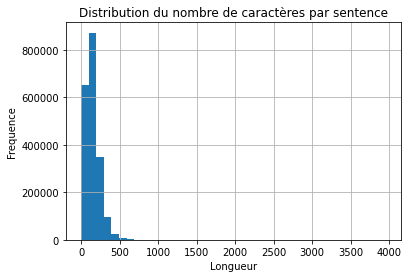

In [ ]:
plt.figure()
plt.grid()
plt.xlabel('Longueur')
plt.ylabel('Frequence')
plt.title("Distribution du nombre de caractères par sentence")
df_text['sentences'].apply(len).hist(bins=40)

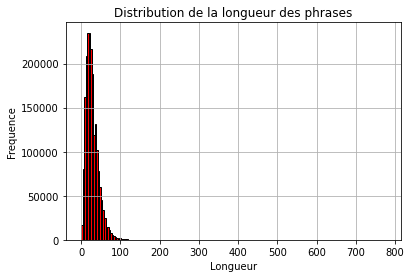

In [ ]:
plt.figure()
plt.grid()
plt.xlabel('Longueur')
plt.ylabel('Frequence')
plt.title("Distribution de la longueur des phrases")
df_text['sentences_tokens'].apply(len).hist(color='red', edgecolor='black', bins=200)